### Blackjack game setting up using openai gym

#### TODO: Compare all the methods under the same simulation

In [1]:
def get_payout_results(num_rounds, num_samples, action_method):
    average_payouts = []
    for sample in range(num_samples):
        current_round = 1
        total_payout = 0  # to store total payout over 'num_rounds'
        
        while current_round <= num_rounds:
            action = action_method()  # take random action 
            obs, payout, is_done, _ = env.step(action)
            total_payout += payout
            if is_done:
                env.reset()  # Environment deals new cards to player and dealer
                current_round += 1
        average_payouts.append(total_payout)
        
    plt.plot(average_payouts)
    plt.xlabel('num_samples')
    plt.ylabel('payout after 1000 rounds')
    plt.show()
    print("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts) / num_samples))


#### The payout given by random pick

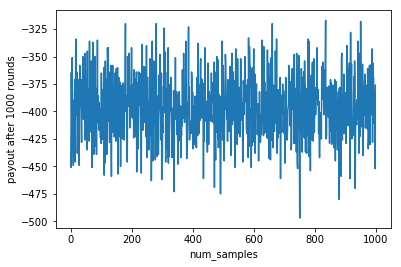

Average payout after 1000 rounds is -395.549


In [2]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples
get_payout_results(num_rounds, num_samples, env.action_space.sample)


#### The payout given by some optimal strategy (rule base)

In [4]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Actions obtained from figure 11 here- https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1

total_payout = 0 # to store total payout over 'num_rounds'

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
        
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))

Average payout after 1000 rounds is -98.504


#### The payout given by basic reinforcement learning method (q_learning etc)

In [5]:
import random

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """

        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

In [62]:
agent.Q

{(4, 1, False): {0: 0.0, 1: 0.0},
 (4, 2, False): {0: 0.8, 1: 0.0},
 (4, 3, False): {0: 0.0, 1: 0.0},
 (4, 4, False): {0: 0.0, 1: 0.0},
 (4, 5, False): {0: 0.0, 1: 0.0},
 (4, 6, False): {0: 0.0, 1: 0.0},
 (4, 7, False): {0: 0.0, 1: 0.0},
 (4, 8, False): {0: 0.0, 1: 0.0},
 (4, 9, False): {0: 0.0, 1: 0.0},
 (4, 10, False): {0: -0.8, 1: -0.3704014692508452},
 (5, 1, False): {0: -0.8, 1: 0.033177600000000036},
 (5, 2, False): {0: -0.8, 1: 0.0},
 (5, 3, False): {0: 0.0, 1: 0.0},
 (5, 4, False): {0: 0.8, 1: 0.0},
 (5, 5, False): {0: 0.0, 1: 0.15757721501446265},
 (5, 6, False): {0: 0.8, 1: 0.0},
 (5, 7, False): {0: 0.0, 1: 0.0},
 (5, 8, False): {0: -0.8, 1: 0.0},
 (5, 9, False): {0: -0.8, 1: 0.0},
 (5, 10, False): {0: 1.9371847680000005, 1: 0.19788182323200018},
 (6, 1, False): {0: -0.8, 1: 0.45187891200000013},
 (6, 2, False): {0: 0.0, 1: 0.0},
 (6, 3, False): {0: -0.8, 1: -0.25345984167936036},
 (6, 4, False): {0: 0.0, 1: 1.0866514950881285},
 (6, 5, False): {0: 0.0, 1: 0.6406653962354689}

Average payout after 1000 rounds after training for 200 episodes is -231.74
Average payout after 1000 rounds after training for 400 episodes is -236.68
Average payout after 1000 rounds after training for 600 episodes is -174.5
Average payout after 1000 rounds after training for 800 episodes is -220.46
Average payout after 1000 rounds after training for 1000 episodes is -203.62
Average payout after 1000 rounds after training for 1200 episodes is -176.3
Average payout after 1000 rounds after training for 1400 episodes is -215.02
Average payout after 1000 rounds after training for 1600 episodes is -185.62
Average payout after 1000 rounds after training for 1800 episodes is -140.34
Average payout after 1000 rounds after training for 2000 episodes is -180.26


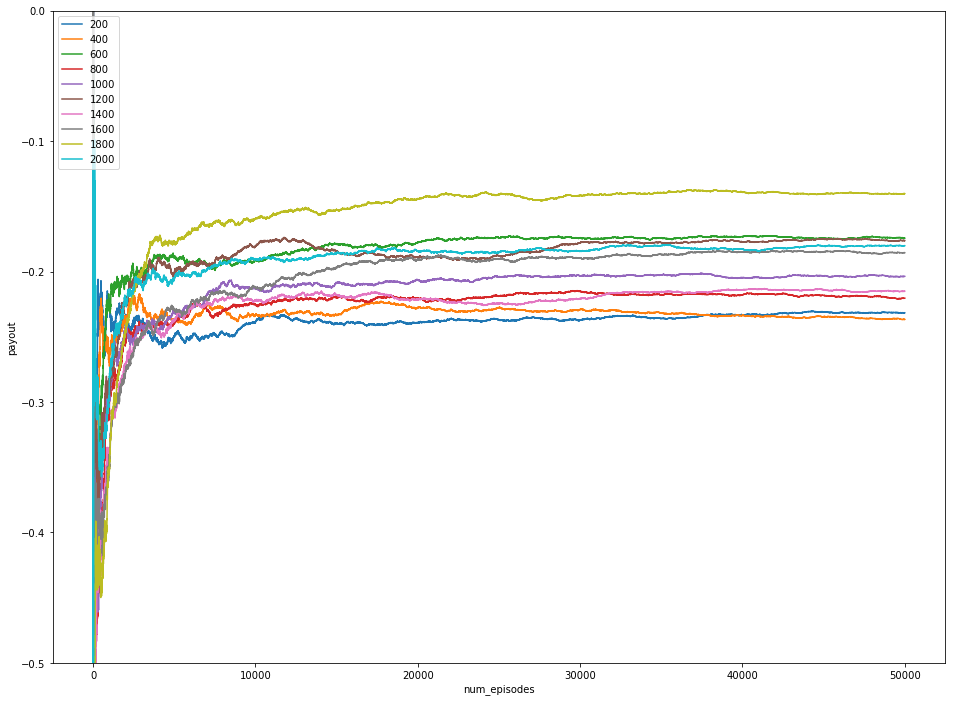

In [6]:
from gym import wrappers
env = gym.make('Blackjack-v0')

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(200, 2200, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                          
# Run simulations over different values of 'num_episodes_to_train' to find the one with best payout
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
    agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

    observation = env.reset()
    for sample in range(num_samples):
        round = 1
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
        while round <= num_rounds:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset() # Environment deals new cards to player and dealer
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
    

# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-0.5,0) # To zoom into this region
plt.show()
env.close()

#### The payout given by basic reinforcement learning method (q_learning etc) with some memory simulation

In [142]:
list(range(200, 2200, 200))

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

### Deep Q learning

In [88]:
import math
import numpy as np

In [49]:
from collections import namedtuple
from itertools import count

In [51]:
# pytorch stuff
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

#### TODO: Transfer the model input into vector format

In [59]:
def transfer_card_input(player, dealer):
    # transfer the dealer and player card into a fixed dimension list
    deal_card = [dealer[0]]
    player_card = player + [0] * (15 - len(player))
    return player_card + deal_card

In [50]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None) # grow the memory
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1)%self.capacity # loop around
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [146]:
BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0

class NetworkAgent(nn.Module):
    
    def __init__(self, n_inputs, n_outputs, gamma):
        self.H = 32 # the number of hidden units (you can change this or make it a parameter)
        self.MEM_SIZE = 10000 # could be made a parmaeter
        self.BATCH_SIZE = 64
        nn.Module.__init__(self)
        self.num_inputs = n_inputs
        self.num_actions = n_outputs
        self.l1 = nn.Linear(self.num_inputs, self.H) # defines the input units and layer 1 weights
        self.l2 = nn.Linear(self.H, 10) # defines the output units (actions) and layer 2 weights
        self.l3 = nn.Linear(10, self.num_actions)
        self.memory = ReplayMemory(self.MEM_SIZE) # create a replay memory 
        self.gamma = gamma
    
    # makes forward predictions from the current state, x, to the actions
    def forward(self, x):
        # the forward function is required by the neural network and takes an input
        # vector (x) representing in this case the current state and makes a prediction
        # about the activation of the output units in the network.
        x = F.relu(self.l1(x)) # state -> hidden -> relu()
        x = F.relu(self.l2(x)) # hidden -> hidden
        x = self.l3(x)
        return x 
    
    # makes a choice about which action to perform (left=0, right=1)
    def choose(self, state):
        #### YOUR CODE HERE
        
        # you should implement a rule for making choices.
        # you can use any of the algorithms discussed in class or that you used in the 
        # earlier part of the homework (softmax, ucb)
        # however, you will want to based your actions somewhat on the network's
        # predictions about what to do:
        # 
        # to give you a hint the following set of lines
        # show how to use the network to make a forward prediction:
        #        state_vec = Variable(FloatTensor([state]), volatile=True).type(FloatTensor)
        #        self(state_vec)
        # specifcally, calling self(state_vec) run the self.forward() function defined above
        
        # right now the algorithm ignores the current state and network
        # but will need to decide based on this later.
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                        math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            state_vec = Variable(FloatTensor([state]), volatile=True).type(FloatTensor)
            action = self(state_vec).max(1)[1].data.numpy()[0]
            return action
        else:
            return random.randrange(2)
        
        
    
    # stores the last state, action pair in a format that is useful to the network
    def remember(self, *args):
        args = (FloatTensor([args[0]]),
               args[1],
               FloatTensor([args[2]]),
               FloatTensor([args[3]]))
        self.memory.push(*args)
    
    def learn(self):
        if len(self.memory) < self.BATCH_SIZE:
            return # don't do learning if you haven't accumulated enough experience yet (this could be improved)
        
        # get a bunch of training data
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
    
        # convert to variables (necessary for batch training)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.from_numpy(np.array(batch_action)).view(self.BATCH_SIZE, -1))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_reward = Variable(torch.cat(batch_reward))
        # steps to be implemented:
        # 1. compute current Q values for all actions
        state_action_values = self(batch_state).gather(1, batch_action)
        
        # 2. compute exected Q values estimated from action which given max Q values (on-policy)
        next_state_values = self(batch_next_state).max(1)[0]
        expected_state_action_values = (next_state_values * self.gamma) + batch_reward

        # 3. compute the loss/error function (one suggestion is F.smooth_l1_loss())
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        
        # 4. apply the error and backprop the gradients
        optimizer.zero_grad()
        loss.backward()
        for param in DQ_agent.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

        
        #### YOUR CODE HERE
        # this is where you will implement the Q-learning update rules on the a batch of
        # sampled examples from the replay memory
        # a couple of resources:
        #  - check out Homework 2, particularly the RNN code for how to train a network using pytorch
        #  - check out the nn.Module docs on the pytorch website: http://pytorch.org/docs/master/nn.html
        #  - check out this pytorch doc on implementing a DQN: http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        # it is ok if you want to modify any of the starter code to use a different
        # format.  However your solution MUST involve a multi-layer neural network as
        # the function approximation representation for the DQN.
        pass

In [139]:
env.reset()

(17, 10, False)

In [140]:
transfer_card_input(env.player, env.dealer)

[7, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10]

In [141]:
DQ_agent.choose(transfer_card_input(env.player, env.dealer))

1

In [144]:
from tqdm import tqdm

  0%|          | 0/50 [00:00<?, ?it/s]

Average payout after 1000 rounds after training for 200 episodes is -515.02


100%|██████████| 50/50 [03:32<00:00,  4.32s/it]

Average payout after 1000 rounds after training for 400 episodes is -519.52


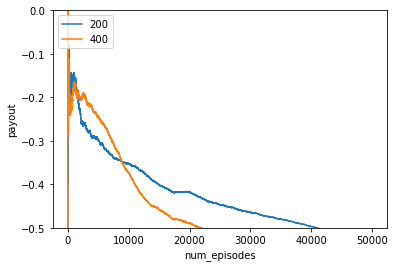

In [150]:
num_episodes_values = range(200, 600, 200)
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
env.reset() 
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
    DQ_agent = NetworkAgent(n_inputs=16, n_outputs=2, gamma=0.7)
    optimizer = optim.RMSprop(DQ_agent.parameters(), lr = 0.0005)
    observation = env.reset()
    for sample in tqdm(range(num_samples)):
        round = 1
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
        while round <= num_rounds:
            state = transfer_card_input(env.player, env.dealer)
            # observation = transfer_card_input(env.player, env.dealer) 
            action = DQ_agent.choose(state)
            # action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            next_state = transfer_card_input(env.player, env.dealer)
            DQ_agent.remember(state, action, next_state, payout)
            DQ_agent.learn()

            total_payout += payout

            if is_done:
                env.reset() # Environment deals new cards to player and dealer
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))


# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-0.5,0) # To zoom into this region
plt.show()
env.close()

#### The payout given by basic reinforcement learning method (q_learning etc) with different betting strategy

#### The payout given by combination of all good results

### Comparison with human performance

### Human tester 1 

### Human tester2

In [7]:
from gym import wrappers
env = gym.make('Blackjack-v0')

In [39]:
env.step(action)

((16, 7, False), -1.0, True, {})

In [40]:
next_observation, payout, is_done, _ = env.step(action)

In [46]:
is_done

True

In [41]:
action = 0

In [42]:
next_observation

(16, 7, False)

In [43]:
payout

-1.0

In [55]:
env.player

[10, 1, 5]

In [54]:
env.dealer

[7, 7, 5]

In [60]:
transfer_card_input(env.player, env.dealer)

[10, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7]